## Практикум 3. Кластеризацiя засобами бiблiотеки Scikit-Learn Python

### Опис методу кластерезації
Спектральна кластерізація - це кластерізація, яка використовує зв'язок точок в графі для визначення кластерів.
Якщо 2 точки знаходятся близко одна від одної, то скоріш за все, вони будуть в 1 кластері.
Для кластерізаціїї метод виконує такі дії:
1)Рахує матрицю подібності точок
2)Проектує на простір меньшої розмірності
3)Знаходить кластери

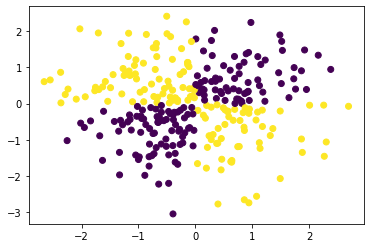

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import warnings
warnings.simplefilter("ignore")
np.random.seed(0)
X=np.random.randn(300,2)
Y=np.logical_xor(X[:,0]>0, X[:,1]>0)
plt.scatter(X[:,0], X[:,1], c=Y, )

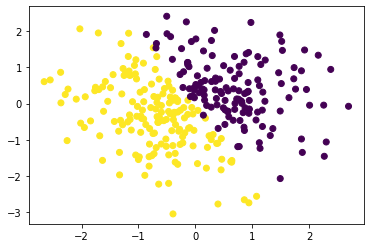

In [2]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=2,
      assign_labels="discretize"
      ).fit(X)
plt.scatter(X[:,0], X[:,1], c=clustering.labels_)

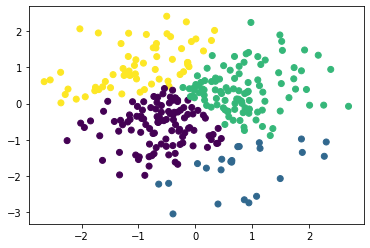

In [3]:
clustering = SpectralClustering(n_clusters=4,
      assign_labels="discretize"
      ).fit(X)
plt.scatter(X[:,0], X[:,1], c=clustering.labels_)

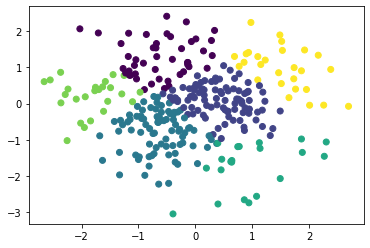

In [4]:
clustering = SpectralClustering(n_clusters=6,
      assign_labels="discretize"
      ).fit(X)
plt.scatter(X[:,0], X[:,1], c=clustering.labels_)

Как видим, метод не может кластеризовать эти данные, так что считать его метрики не очень целесообразно.
Оно и понятно, ведь спектральная кластеризация не подходит, потому что данные слабо визуально различимы,
и модель не разделяет нелинейно преобразованные данные. Да и в принципе, она не представляет
каким методом она должна разделить - ведь это просто порезанное руками гауссовское распределение,
а как мы его разрезали лишь одному богу известно.
Есть метод AffinityPropagation который разрезает такой массив на 4 равные части,
очень похожие на изначальные данные, но, к сожалению, мне он не выпал.

## Второй набор данных

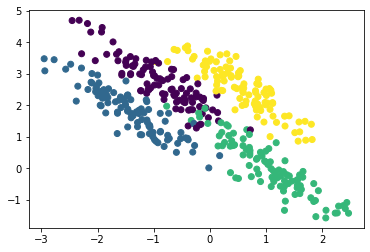

In [5]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X, y_true = make_blobs( n_samples =400, centers =4,
cluster_std=0.90 , random_state=0)

rng = np.random.RandomState (13 )
X = np.dot(X, rng.randn( 2 , 2 ) )
#X = StandardScaler().fit_transform(X)
plt.scatter(X[:,0], X[:,1], c=y_true )

Выполним кластеризацию

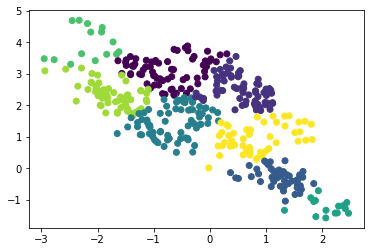

In [6]:
def create_def_cluster(X):
    clustering = SpectralClustering(
          assign_labels="discretize").fit(X)
    return clustering

clustering=create_def_cluster(X)
plt.scatter(X[:,0], X[:,1], c=clustering.labels_)

In [7]:
from sklearn import metrics as metrics
def printScores(X, y_true, labels):
    print("Estimated number of clusters: ",
          len(set(labels)))
    print("Adjusted Rand Index: ",
          metrics.adjusted_rand_score(y_true, labels))
    print("Adjusted Mutual Information: ",
          metrics.adjusted_mutual_info_score(y_true, labels))
    print("Silhouette Coefficient: ",
          metrics.silhouette_score(X, labels))
    return [len(set(labels)),
    metrics.adjusted_rand_score(y_true, labels),
    metrics.adjusted_mutual_info_score(y_true, labels),
    metrics.silhouette_score(X, labels)]

In [8]:
printScores(X, y_true, clustering.labels_)

Estimated number of clusters:  8
Adjusted Rand Index:  0.37662963791346704
Adjusted Mutual Information:  0.5174614904369073
Silhouette Coefficient:  0.372710346136977


[8, 0.37662963791346704, 0.5174614904369073, 0.372710346136977]

6. Побудувати декiлька альтернативних моделей:
• шляхом змiни значень параметрiв основної моделi,
• використати рiзнi функцiї вiдстанi,
• задати рiзнi значення кiлькостi кластерiв, де кiлькiсть кластерiв -
параметр алгоритму.

In [9]:
def getScores(X, y_true, labels):
    return [len(set(labels)),
            metrics.adjusted_rand_score(y_true, labels),
            metrics.adjusted_mutual_info_score(y_true, labels),
            metrics.silhouette_score(X, labels)]

In [10]:
def createClusteringModel(X, y_true, n_clusters, affinity, n_neighbors, gamma=1.0):
    clustering = SpectralClustering(n_clusters=n_clusters,
                                    affinity=affinity,
                                    n_neighbors=n_neighbors,
                                    gamma=gamma,
                                    eigen_solver='arpack').fit(X)
    plt.scatter(X[:,0], X[:,1], c=clustering.labels_)
    scores=getScores(X, y_true, clustering.labels_)
    return clustering, scores

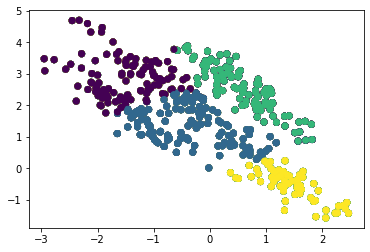

In [11]:
affinities=['nearest_neighbors', 'rbf']
n_clusters=range(2,10)
n_neighbors=range(1, 15)
models_rbf=[]
scores_rbf=[]
models_nn=[]
scores_nn=[]
for n_c in n_clusters:
    model, score=createClusteringModel(X, y_true, n_c, 'rbf', n_neighbors=1)
    models_rbf.append(model)
    scores_rbf.append(score)
for neighbors in n_neighbors:
    model, score=createClusteringModel(X, y_true,
                                       4,#ну все варианты рисовать ето наверное очень много графиков, потом все равно делать автоматический вібор
                                       'nearest_neighbors',
                                       neighbors)
    models_nn.append(model)
    scores_nn.append(score)

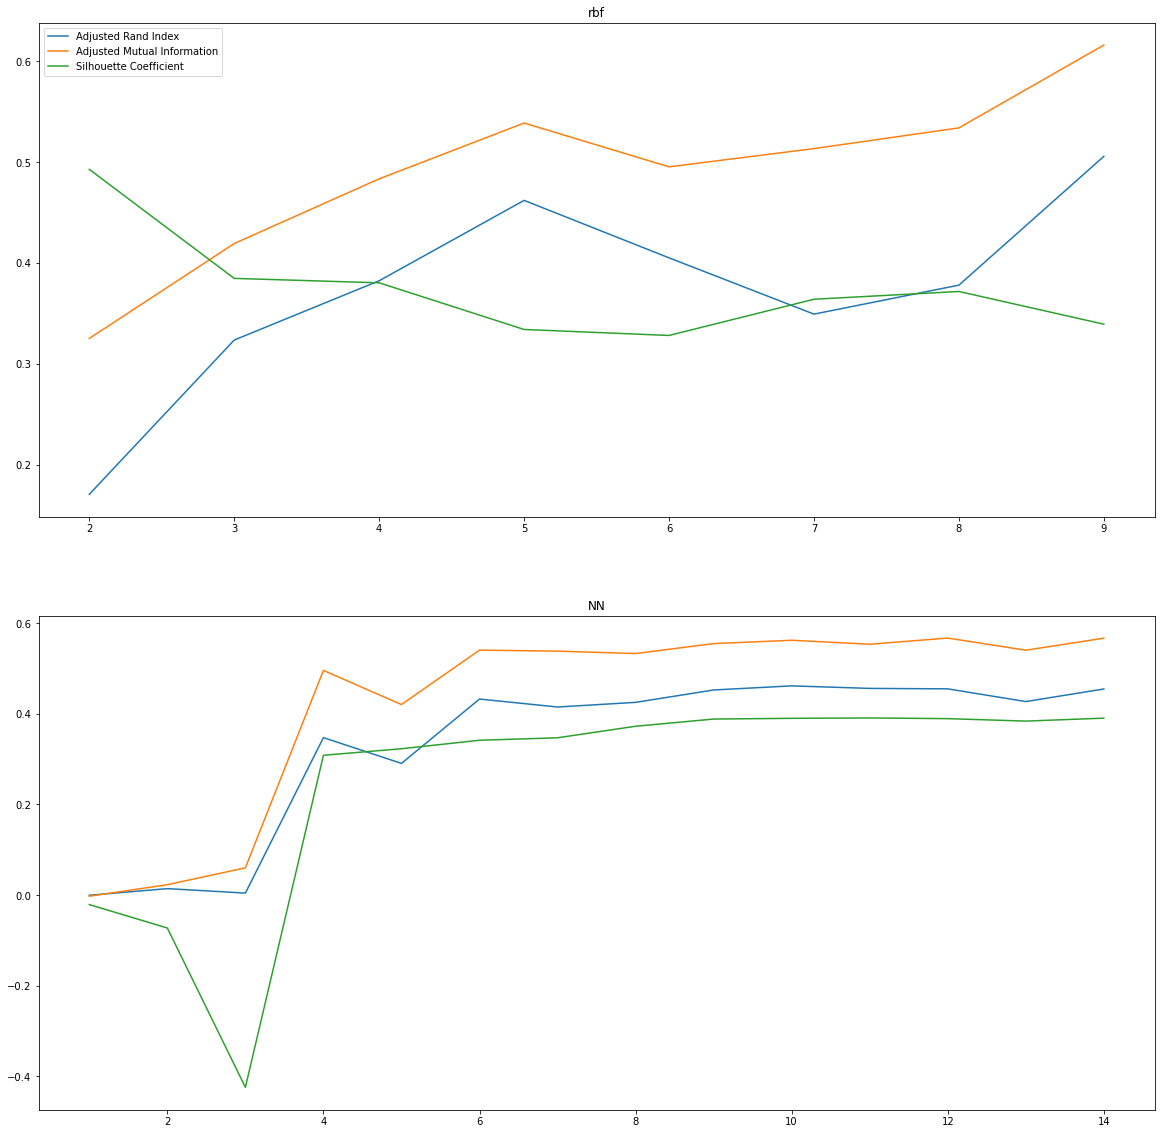

In [12]:
#Красиво нарисуем
fig, (ax1, ax2) =plt.subplots(2, figsize=(20,20))
ax1.set_title('rbf')
ax1.plot(n_clusters, np.array(scores_rbf)[:,1:4])
ax1.legend(['Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient'])
ax2.set_title('NN')
#ax2.legend(['Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient'], loc='upper right')
ax2.plot(n_neighbors, np.array(scores_nn)[:,1:4])

При збільшенні кількості кластерів якість моделі падає 
(по silhouette score, бо методики порівняння відповідності перших двох метрик при різній кількості кластерів в моделі і в true_labels для мене залишається загадкою), а при збільшенні кількості "сусідів"
для визначення приналежності - росте, але швидко стабілізується

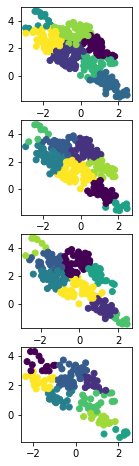

In [13]:
from sklearn.model_selection import train_test_split
fig, axs=plt.subplots(4, figsize=(2,8))
model=create_def_cluster(X)
axs[0].scatter(X[:,0], X[:,1], c=model.labels_)
for i in range(1,4):
    x_splitted, _, y_splitted, _=train_test_split(X, y_true, test_size=0.2*i)
    model=create_def_cluster(x_splitted)
    axs[i].scatter(x_splitted[:,0], x_splitted[:,1], c=model.labels_)

In [14]:
del models_nn
del models_rbf
del scores_rbf
del scores_nn

Як ми можемо бачити з зображень зі зменьшинням кількості точок кластери змінюються, але в цілому їх
місцезнаходження залишаеться тим самим

## Краща модель
Cпробуємо повний пошук, не знаючи оптимальну кількість кластерів

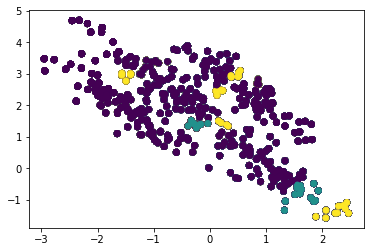

In [15]:
affinities=['nearest_neighbors', 'rbf']
n_clusters=range(3,10)
n_neighbors=range(3, 15)
gamma=(0.01*i for i in range(1, 1000, 10))
models=[]
scores=[]
for aff in affinities:
    for n_c in n_clusters:
        for neighbors in n_neighbors:
            for g in gamma:
                model, score=createClusteringModel(X, y_true,
                                                   n_c,
                                                   aff,
                                                   neighbors,
                                                   g)
                models.append(model)
                scores.append(score)
#пошук кращої моделі silhouette_score
best_score_pos=np.argmax(np.array(scores)[:,3])
model=models[best_score_pos]
best_score=scores[best_score_pos]
plt.scatter(X[:,0], X[:,1], c=model.labels_)

Автоматичний пошук вважає, що це найкраща модель. Нажаль, це неправильно.
Спробуємо руками позначити потрібну кількість кластерів

Best model according to silhouette score:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
                   coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
                   gamma=0.1, kernel_params=None, n_clusters=4,
                   n_components=None, n_init=10, n_jobs=None, n_neighbors=11,
                   random_state=None)>
Estimated number of clusters:  4
Adjusted Rand Index:  0.45559210403960626
Adjusted Mutual Information:  0.5530384088170754
Silhouette Coefficient:  0.3904179118447739


[4, 0.45559210403960626, 0.5530384088170754, 0.3904179118447739]

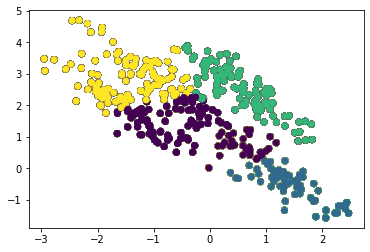

In [16]:
#добавим некоторые кернелы из pairwise_kernels, но лучше не стало - они только переодически ломают код
affinities=['nearest_neighbors', 'rbf', ]#+[ 'poly','polynomial', 'laplacian', 'sigmoid']
n_neighbors=range(5, 15)
gamma=[0.01*10**i for i in range(5)]
models=[]
scores=[]
for aff in affinities:
    for neighbors in n_neighbors:
        for g in gamma:
            model, score=createClusteringModel(X, y_true,
                                                4,
                                                aff,
                                                neighbors,
                                                g)
            models.append(model)
            scores.append(score)
#пошук кращої моделі по silhouette_score
best_score_pos=np.argmax(np.array(scores)[:,3])
model=models[best_score_pos]
best_score=scores[best_score_pos]
plt.scatter(X[:,0], X[:,1], c=model.labels_)
print("Best model according to silhouette score: ", model.get_params)
printScores(X, y_true, model.labels_)

Це розбиття теж не є вірним
Спробуємо дізнатися, яке розбиття краще всього працює, знаючи інформацію о правильних классах

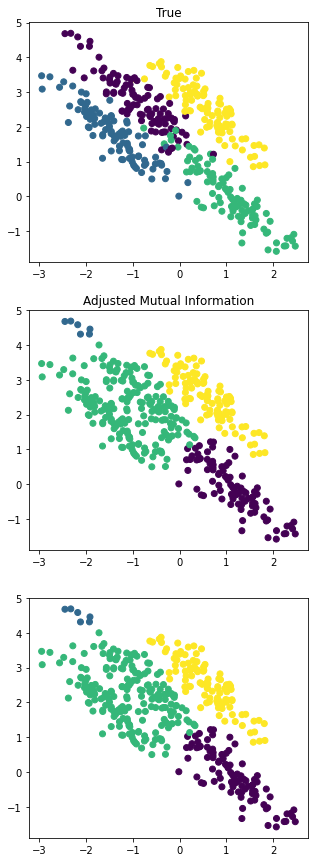

In [17]:
#Adjusted Rand Index',
best_score_pos_1=np.argmax(np.array(scores)[:,1])
model_1=models[best_score_pos_1]
best_score_1=scores[best_score_pos_1]
fig, (ax1, ax2, ax3)=plt.subplots(3, figsize=(5,15))
ax1.set_title('True')
ax1.scatter(X[:,0], X[:,1], c=y_true)
ax2.set_title('Adjusted Rand Index')
ax2.scatter(X[:,0], X[:,1], c=model_1.labels_)
#Adjusted Mutual Information
best_score_pos_2=np.argmax(np.array(scores)[:,2])
model_2=models[best_score_pos_2]
best_score_2=scores[best_score_pos_2]
ax2.set_title('Adjusted Mutual Information')
ax3.scatter(X[:,0], X[:,1], c=model_2.labels_)

## Висновки
Правильно визначено 2 кластери! На жаль, 2 інших кластера злилися.
У моделі скінчилися параметри, які можно змінювати, щоб отримати кращій результат.
Хоча цей спосіб кластерізації в теорії повинен видавати дещо кращі результати на подібних данних, але взагалі він 
гарно показує себе на високорозмірних просторах (non-flat geometry).
Таким чином, кращою моделлю для кластерізації для 2 набору данних з запропонованих є:

In [18]:
#Результат однаковий, тому візьмемо першу модель
model=model_1
print("Параметри: ", model.get_params)
print("Оцінки: ")
printScores(X, y_true, model.labels_)


Параметри:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=10.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=5, random_state=None)>
Оцінки: 
Estimated number of clusters:  4
Adjusted Rand Index:  0.5953299634549319
Adjusted Mutual Information:  0.6867634494212524
Silhouette Coefficient:  0.365897385897962


[4, 0.5953299634549319, 0.6867634494212524, 0.365897385897962]